In [1]:
import anndata
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import warnings

path_results = "Exploration_results/"

Import and subset data:

In [2]:
path_data = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path_data, backed = 'r')

# subset smg
smg = adata[adata.obs["ann_level_3"] == 'Submucosal Secretory'].to_memory()

# subset serous
serous = smg[smg.obs["ann_level_4"] == 'SMG serous'].to_memory()

Palette for cell type distribution:

In [3]:
type_palette = sns.color_palette(palette='tab20b')
type_palette[0], type_palette[1], type_palette[2], type_palette[3] = type_palette[0], type_palette[2], type_palette[16], type_palette[18]

Palette for dataset distribution:

In [4]:
dataset_colors = sns.color_palette("Set2")
dataset_colors[0], dataset_colors[2] = dataset_colors[2], dataset_colors[0]

# re-order datasets
order = serous.obs["dataset"].value_counts().index.tolist()
serous.obs["dataset"] = pd.Categorical(serous.obs["dataset"], categories=order, ordered=True)

Outlier removal:

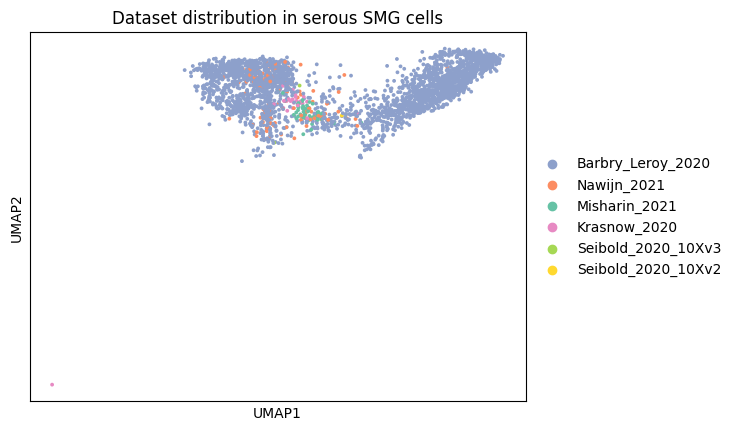

In [5]:
sc.pl.umap(serous, color = "dataset", legend_fontsize = 10, size = 30, palette = dataset_colors, title = 'Dataset distribution in serous SMG cells')

We see that there is one outlier (bottom left corner) --> remove it from the plots; the filtered set of cells will be used from now on (also for donor distribution).

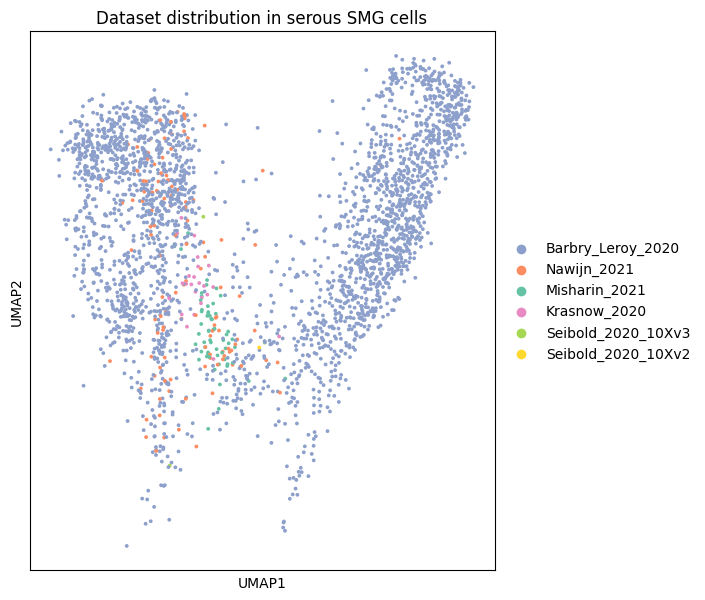

In [6]:
umap_coords = serous.obsm['X_umap']

x_min, x_max = -100, 100
y_min, y_max = 5, 100 # trial and error to remove the outlier

mask = (
    (umap_coords[:, 0] >= x_min) &
    (umap_coords[:, 0] <= x_max) &
    (umap_coords[:, 1] >= y_min) &
    (umap_coords[:, 1] <= y_max)
)

serous_filtered = serous[mask].copy()

plt.rcParams["figure.figsize"] = [6,7]
ax = sc.pl.umap(serous_filtered, color = "dataset", legend_fontsize = 10, size = 30, palette = dataset_colors,
           title = 'Dataset distribution in serous SMG cells', show = False)

Counts and color map for dataset barplot:

In [7]:
dataset_counts = serous_filtered.obs.groupby(['ann_finest_level', 'dataset'], observed=False).size().unstack(fill_value=0)
dataset_props = dataset_counts.div(dataset_counts.sum(axis=1), axis=0) # get proportions
# set colors:
color_map = {ds: dataset_colors[i] for i, ds in enumerate(order)}
colors = [color_map[d] for d in dataset_props.columns]

Clean up and inspect donors:

In [8]:
# shorten donor ID
serous_filtered.obs['short_donor_id'] = serous_filtered.obs['donor_id'].apply(lambda x: x.split('_')[-1])

# filter by sub-type
bronchial = serous_filtered.obs[serous_filtered.obs['ann_finest_level'] == 'SMG serous (bronchial)']
nasal = serous_filtered.obs[serous_filtered.obs['ann_finest_level'] == 'SMG serous (nasal)']

# count cells per donor
bronchial_counts = bronchial['short_donor_id'].value_counts()
nasal_counts = nasal['short_donor_id'].value_counts()
top_nasal = nasal_counts.idxmax()

The top nasal donor is female; we manually determine its (sex-coded) color:

In [9]:
print(f'Top nasal: {serous_filtered[serous_filtered.obs['short_donor_id'] == top_nasal].obs['sex'].unique()}')

Top nasal: ['female']
Categories (1, object): ['female']


In [10]:
# define colors
darkred = "#8B0000" # for top nasal donor
grey = "#adadad"  # for other donors

# build palette mapping donor -> color
palette = {}
for donor in serous_filtered.obs['short_donor_id'].unique():
    if donor == top_nasal:
        palette[donor] = darkred
    else:
        palette[donor] = grey

Counts and color map for donor barplot:

In [11]:
donor_counts = serous_filtered.obs.groupby(['ann_finest_level', 'short_donor_id'], observed=False).size().unstack(fill_value=0)
donor_props = donor_counts.div(donor_counts.sum(axis=1), axis=0)

# organize data:
plot_data = {}

for subtype in donor_props.index:
    segments = {}
    
    if subtype == "SMG serous (bronchial)":
        if top_nasal in donor_props.columns:
            segments["top_nasal"] = donor_props.loc[subtype, top_nasal]
        segments["others"] = donor_props.loc[subtype].drop([top_nasal], errors="ignore").sum()

    else: # nasal subtype
        if top_nasal in donor_props.columns:
            segments["top_nasal"] = donor_props.loc[subtype, top_nasal]
        segments["others"] = donor_props.loc[subtype].drop([top_nasal], errors="ignore").sum()

    plot_data[subtype] = segments

**Full figure:**

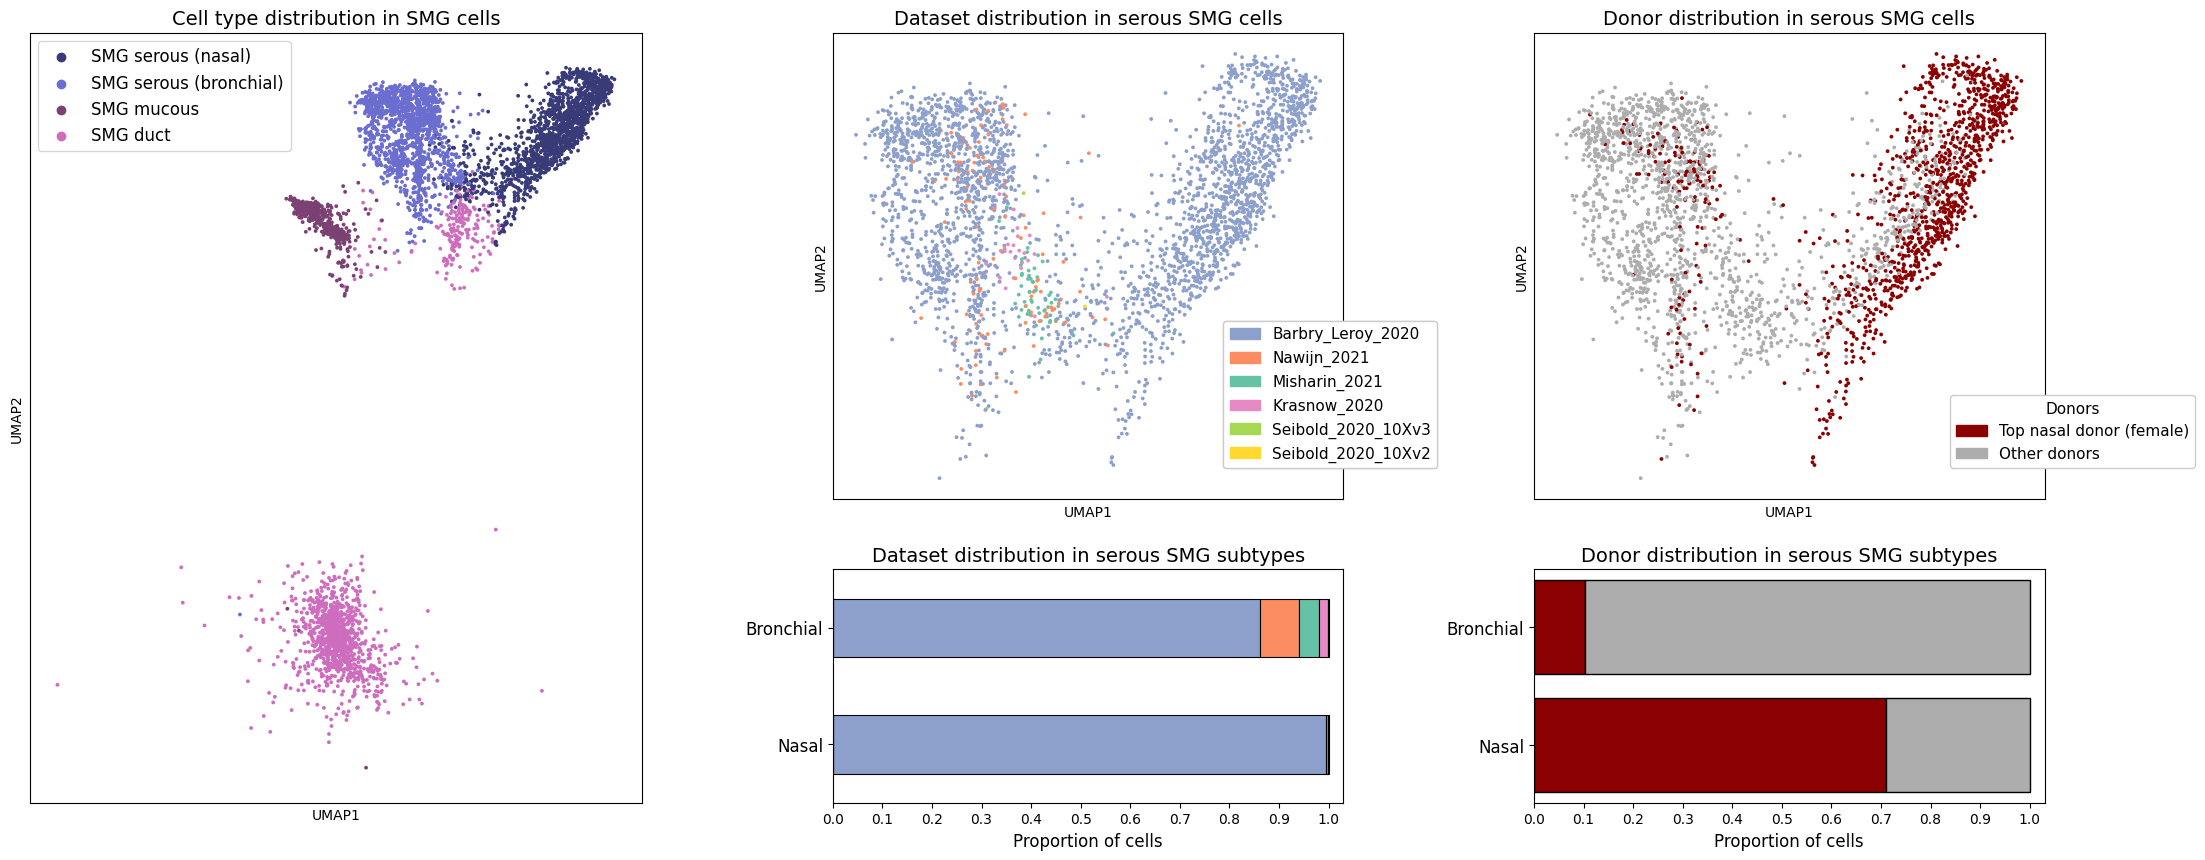

In [12]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(26, 10))  # wide to fit 3 panels

gs = gridspec.GridSpec(2, 3, width_ratios=[1.2, 1, 1], height_ratios=[2, 1], hspace=0.2, wspace=0.35)
    # middle and right cols are split into 2 (umap + bar), while left col spans both rows

### LEFT: Cell type distribution
ax1 = fig.add_subplot(gs[:, 0])
sc.pl.umap(
    smg,
    color="ann_finest_level",
    legend_fontsize=12,
    size=30,
    palette=type_palette,
    title="Cell type distribution in SMG cells",
    legend_loc = 'upper left',
    ax=ax1,
    show=False
)
ax1.set_title(ax1.get_title(), fontsize=14)


### MIDDLE: Dataset distribution
# UMAP
ax2 = fig.add_subplot(gs[0, 1])
sc.pl.umap(
    serous_filtered,
    color="dataset",
    legend_fontsize=10,
    size=30,
    palette=dataset_colors,
    title="Dataset distribution in serous SMG cells",
    legend_loc = None,
    ax=ax2,
    show=False
)
ax2.set_title(ax2.get_title(), fontsize=14)


dataset_handles = [mpatches.Patch(color=color_map[ds], label=ds) for ds in order]
dataset_legend = ax2.legend(
    handles=dataset_handles,
    bbox_to_anchor=(0.75, 0.225),  
    loc="center left",
    framealpha=1,
    fontsize = 11
)
ax2.add_artist(dataset_legend)

# barplot
ax3 = fig.add_subplot(gs[1, 1])
dataset_counts = serous_filtered.obs.groupby(['ann_finest_level', 'dataset'], observed=False).size().unstack(fill_value=0)
dataset_props = dataset_counts.div(dataset_counts.sum(axis=1), axis=0)

color_map = {ds: dataset_colors[i] for i, ds in enumerate(order)}
colors = [color_map[d] for d in dataset_props.columns]

dataset_props.plot(
    kind="barh",
    stacked=True,
    color=colors,
    legend=False,
    edgecolor="black",
    lw=0.8,
    ax=ax3
)
ax3.set_title("Dataset distribution in serous SMG subtypes", fontsize = 14)
ax3.set_xlabel("Proportion of cells", fontsize = 12)
ax3.set_ylabel(None)
ax3.set_yticklabels([lbl.get_text().replace("SMG serous (", "").replace(")", "").capitalize() 
                     for lbl in ax3.get_yticklabels()], fontsize = 12)
ax3.set_xlim(0, 1.03)
ax3.set_xticks(np.linspace(0, 1, 11))


### RIGHT: Donor distribution
# UMAP
ax4 = fig.add_subplot(gs[0, 2])
sc.pl.umap(
    serous_filtered,
    color=["short_donor_id"],
    palette=palette,
    size=30,
    title="Donor distribution in serous SMG cells",
    legend_loc=None,
    ax=ax4,
    show=False
)
ax4.set_title(ax4.get_title(), fontsize=14)


handles = [
    mpatches.Patch(color=darkred, label=f"Top nasal donor (female)"),
    mpatches.Patch(color=grey, label="Other donors"),
]

ax4.legend(handles=handles, title="Donors", bbox_to_anchor=(0.8, 0.24), 
                          loc="upper left", framealpha = 1, fontsize = 11, title_fontsize = 11)


# barplot
ax5 = fig.add_subplot(gs[1, 2])
for subtype, segments in plot_data.items():
    left = 0
    if "top_nasal" in segments:
        ax5.barh(subtype, segments["top_nasal"], left=left, color=darkred, edgecolor="black")
        left += segments["top_nasal"]
    if "others" in segments:
        ax5.barh(subtype, segments["others"], left=left, color=grey, edgecolor="black")

ax5.set_title("Donor distribution in serous SMG subtypes", fontsize = 14)
ax5.set_xlabel("Proportion of cells", fontsize = 12)
ax5.set_ylabel(None)
ax5.set_yticklabels([lbl.get_text().replace("SMG serous (", "").replace(")", "").capitalize()  
                     for lbl in ax5.get_yticklabels()], fontsize = 12)
ax5.set_xlim(0, 1.03)
ax5.set_xticks(np.linspace(0, 1, 11))

fig.savefig(f"{path_results}SMGs.png", dpi=300, bbox_inches="tight")
plt.show()